In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from CreateCrimeRatioTable import CreateCrimeRatioTable
from functions1 import removingJunk,makingAggTable,makeRatio,plotTogether,housePred
from FindCorrelation import FindCorrelation
from PlotCorrelation import PlotCorrelation
from LinearRegressionCrime import predictForAllNeighborhood, FindRatio

### Introduction

This project is about analyzing crimes and house prices in Chicago. Based on the different house prices of different neighborhoods and the crime occurrence in those areas, our goal is to determine whether there is correlation between the crime rates and house prices in different neighborhoods. We have analyzed chicago crime data and median sale price of houses of different neighborhoods in Chicago. We have calculated the correlations between change in house prices and number of crimes in different neighborhoods from 2012-2018 and we came to a conclusion on whether or not there is a connection between them based on available data. Furthurmore, we have predicted house prices and number of crimes for two more years and shown that the predicted data also supports our conclusion. 

In [29]:
CrimeFile = 'D:/CS 418/Project/Merged/0To2043066.csv'
CrimeDF = pd.read_csv(CrimeFile, keep_default_na=False)
housedata = pd.read_csv("neighborActualFiltered.csv", usecols=range(1,5), keep_default_na=False)
housedata=housedata[housedata['Median Ppsf']!='']
housedata.head()
HousePriceDF=housedata.copy()

C:\Users\shafi\Anaconda3\envs\cs418env\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (6,9,14,17,21,22,23,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Cleaning

We have used two different datasets for this project:

1. Chicago crime data from city of chicago website: https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data
2. Chicago house prices data from redfin: https://www.redfin.com/blog/data-center

Since we have house price of chicago neighborhood from 2012-2018, we got rid of all the crimes which occurred before 2012 and after 2018. We also got rid of the rows with null values. There is no separate script for cleaning the crime data. Data before 2012 and after 2018 was filtered out when we downloaded the dataset. For removing rows with null values, we checked for null values before every operations. We ignored the rows which have a null value. 

After getting the house price data, we removed those column where there was no value available. We also planned to work with price per square feet value. So we keep Price per square and sale price and filtered out the rest. Each neighborhood name had unnecessary part. We removed that part, too.

In [30]:
HousePriceDF = removingJunk(HousePriceDF)

CrimeDF = CrimeDF[CrimeDF['Neighborhood'] != '']
CrimeDF = CrimeDF[CrimeDF['Year'] != 2011]
CrimeDF = CrimeDF[CrimeDF['Year'] != 2019]

### Exploratory Data Analysis

In our project we are using two datasets: Chicago Crime Data and House Prices Data.

#### Chicago Crime Data: 
This dataset contains the criminal offences occurred in Chicago from 2001-2019. However, we are going to use crime data in 2012-2019. Each record in this dataset represents the details of a crime that happened in Chicago. The details include the time, type, description, location etc. of the crime. However, we are only going to use time and location of every crime. In this dataset, the neighborhood or the zipcode of the location of the crime is not given. Since, our goal is to analyze the crime happening in Chicago based on different areas and their relationship with the economy of those areas, we had to extract the neighborhoods from the location given in coordinates. We used the ArcGIS API to extract the neighborhoods. However, it is taking a huge amount of time to extract the neighborhoods with ArcGIS API. Although our whole dataset contains more than 2 million records, we are currently experimenting with half a million. We will use the whole dataset before our final submission. The function used for extracting the neighborhood data is given below.

#### House Prices Data from Redfin: 
Redfin provides the data of home sale prices from 2012-2019. Each record represents a 90-day period. Each row includes median sale price, median price per square foot, median listed price, number of houses sold within that 90-day period in a particular neighborhood. We are going to relate our 2 datasets using their neighborhood.

Some of the rows from out data sets are shown below:

We used only a few columns of the crime dataset for our project:

In [31]:
CrimeDF[['Year','Primary Type','X Coordinate', 'Y Coordinate','Neighborhood']].head()

,Year,Primary Type,X Coordinate,Y Coordinate,Neighborhood
0,2015,BATTERY,1144606.0,1903566.0,Austin
1,2015,OTHER OFFENSE,1166468.0,1860715.0,West Englewood
2,2015,BATTERY,1185075.0,1875622.0,Kenwood
3,2015,BATTERY,1178033.0,1870804.0,Washington Park
4,2015,ROBBERY,1144920.0,1898709.0,Austin


In [32]:
HousePriceDF.head()

,Region,Period Begin,Median Ppsf,Median Sale Price
0,Albany Park,11/1/2011,78.4,$154K
1,Albany Park,12/1/2011,76.8,$122K
2,Albany Park,1/1/2012,77.92991453,$129K
3,Albany Park,2/1/2012,80.89870409,$131K
4,Albany Park,3/1/2012,98.3973108,$141K


### Data Transformation
To perform our experiments, we had to make a few transfomations to our data. We had to aggregate the crime data based on the count of crimes in each year in each neighborhood and calculated their ratio. The following function both of these things and writes them into csv files.

In [33]:
CreateCrimeRatioTable(CrimeDF,'CrimeRatioTable.csv','CrimeCountTable.csv')

After aggregating the data based on the count of crimes in each neighborhood by year, the crime data looks as follows:

In [34]:
CrimeCountTable = pd.read_csv('CrimeCountTable.csv',usecols=range(1,9))
CrimeCountTable.head()

,Neighborhood,2012,2013,2014,2015,2016,2017,2018
0,Albany Park,2956,2708,2404,2481,2383,2456,2415
1,Andersonville,517,466,382,419,407,500,527
2,Archer Heights,1251,1299,1076,1000,893,864,855
3,Armour Square,787,649,568,544,510,529,492
4,Ashburn,2110,2143,2033,1690,1883,1874,1802


Crime ratio for each year was calculated with this formula: 
Ratio = (value for a neighborhood)/(sum of value for all neighborhoods). After calculating the crime ratio our data looks like the following:


In [35]:
CrimeRatioTable = pd.read_csv('CrimeRatioTable.csv',usecols=range(1,9))
CrimeRatioTable.head()

,Neighborhood,2012,2013,2014,2015,2016,2017,2018
0,Albany Park,0.008974,0.009013,0.008961,0.009896,0.009255,0.009439,0.009327
1,Andersonville,0.001570,0.001551,0.001424,0.001671,0.001581,0.001922,0.002035
2,Archer Heights,0.003798,0.004324,0.004011,0.003989,0.003468,0.003321,0.003302
3,Armour Square,0.002389,0.002160,0.002117,0.002170,0.001981,0.002033,0.001900
4,Ashburn,0.006406,0.007133,0.007578,0.006741,0.007313,0.007202,0.006960


Similarly, house price data was aggregated the following way:

In [36]:
HousePriceAggregated = makingAggTable(HousePriceDF)
HousePriceAggregated.head()

,Region,2012,2013,2014,2015,2016,2017,2018
0,Albany Park,93.062070,116.903397,139.914415,161.251708,166.746980,180.237282,178.734439
1,Andersonville,184.337836,208.289592,221.668547,231.906399,245.259777,250.123551,252.408994
2,Arcadia Terrace,76.099988,122.293995,135.938735,130.042807,145.536179,149.176003,168.142864
3,Archer Heights,92.709469,115.030644,114.896564,115.273792,122.026048,130.403410,149.643161
4,Ashburn,86.910210,93.730106,105.626761,113.026044,123.249076,138.113684,144.153547


And, we also calculated the ratio of house prices for each neighborhood by year

In [37]:
HousePriceRatio = makeRatio(HousePriceAggregated,7)
HousePriceRatio.head()

,Region,2012,2013,2014,2015,2016,2017,2018
0,Albany Park,0.004336,0.004805,0.005217,0.005721,0.005535,0.005642,0.005392
1,Andersonville,0.008589,0.008562,0.008265,0.008228,0.008141,0.007830,0.007615
2,Arcadia Terrace,0.003546,0.005027,0.005069,0.004614,0.004831,0.004670,0.005072
3,Archer Heights,0.004320,0.004728,0.004284,0.004090,0.004050,0.004082,0.004514
4,Ashburn,0.004050,0.003853,0.003938,0.004010,0.004091,0.004324,0.004349


#### Road to Hypothesis
We plotted the house price(ratio) and crime price(ratio) trends. Around 75% are inverse to each other.

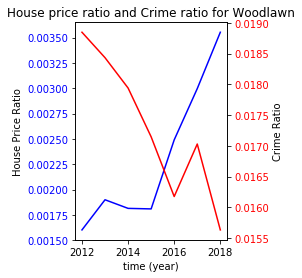

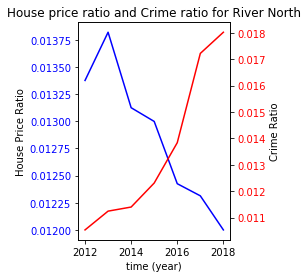

In [38]:
plotTogether('Woodlawn',CrimeRatioTable,HousePriceRatio)
plotTogether('River North',CrimeRatioTable,HousePriceRatio)

### Hypothesis:
From EDA, we hypothesize that there is an inverse relationship between change in house price ratio and change in crime ratio. In other words, we want to show that there is a strong negative correlation between house price ratio and crime ratio. 

### Correlations:
We calculated the pearson correlation coefficient between house price ratio and crime ratio for each neighborhood and plotted them in a graph. It was observed that 77.33% had a negative correlation between crime ratio and house price ratio and 22.67% neighborhoods showed a positive correlation

In [39]:
#HousePriceRatio = pd.read_csv('neighborByYearRatio.csv',usecols=range(1,9))
FindCorrelation(CrimeRatioTable, HousePriceRatio,'Correlation_ratio.csv')


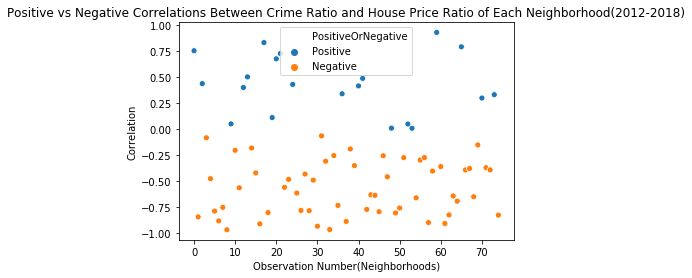

In [2]:
Correlations = pd.read_csv('Correlation_ratio.csv', usecols=range(1,5))
PlotCorrelation(Correlations,'PositiveOrNegative','Positive vs Negative Correlations Between Crime Ratio and House Price Ratio of Each Neighborhood(2012-2018)')

### ML Analysis
Given that we only had data for only 7 years, we wanted to check if the correlations were projected to change for future data. Linear regression was used to predict number of crimes and household prices in the neighbourhood for 2 more years(2019,2020). After prediction, the ratios for those years were calculated.

In [ ]:
neighborhoods = CrimeDF['Neighborhood'].unique()
groupedByNeighbourhood = CrimeDF.groupby('Neighborhood')
pred = predictForAllNeighborhood(groupedByNeighbourhood,neighborhoods)



In [ ]:
FindRatio(pred,CrimeRatioTable,'CrimeRatioWithPredicted.csv')

In [3]:
CrimeRatioWithPredicted = pd.read_csv('CrimeRatioWithPredicted.csv',usecols=range(1,11))

In [43]:
HousePriceWithPredicted = housePred(HousePriceDF,HousePriceAggregated)

In [47]:
HousePriceWithPredictedRatio=makeRatio(HousePriceWithPredicted, 9)

Now, if recalculate the correlations and plot those, we will still see that there is a higher percentage of negative correlations than that of negative correlations: negative 53.33%, positive 47.67%

In [48]:
FindCorrelation(CrimeRatioWithPredicted, HousePriceWithPredictedRatio,'Correlation_ratio_with_predicted.csv')

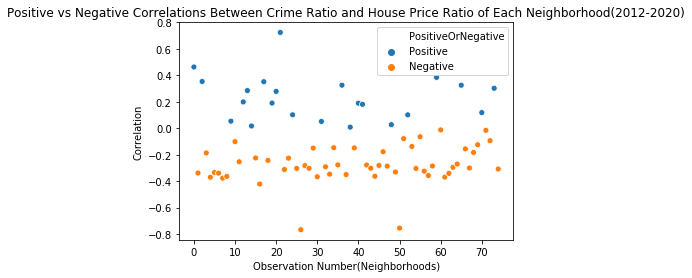

In [5]:
CorrelationsWithPredicted = pd.read_csv('Correlation_ratio_with_predicted.csv', usecols=range(1,5))
PlotCorrelation(CorrelationsWithPredicted,'PositiveOrNegative','Positive vs Negative Correlations Between Crime Ratio and House Price Ratio of Each Neighborhood(2012-2020)')

### Significance of Correlations:
